In [1]:
import pathlib
import os

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [3]:
date = "28_10_2023"
fly = "R60D05_lexOpjRGECO1a_R4d_sytjGCaMP7f_fly1"
session = 'baseline-000'
basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/')
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

h5name = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/data.h5'
if not os.path.exists(h5name):
    tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'], first_chan=1)
    st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)

(227, 257)
[                                        ] | 0% Completed | 1.53 s ms

<tifffile.read_uic_tag> failed reading CreateTime with ValueError: no datetime before year 1 (julianday=0)
<tifffile.read_uic_tag> failed reading CreateTime with ValueError: no datetime before year 1 (julianday=0)


[########################################] | 100% Completed | 122.97 s


In [4]:
f = h5py.File(h5name)
data = f['/data'][:]



In [5]:
data.shape

(2, 3999, 7, 227, 257)

In [6]:
ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[1,:,:,:], in_place=False)


In [7]:
shifts.shape

(2, 3999, 7)

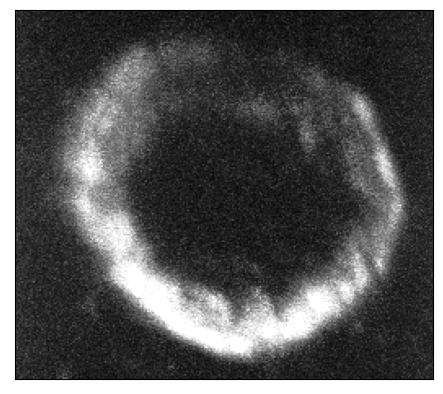

In [8]:
fig, ax = plt.subplots()
# ax.imshow(ref_img[0,:,:,:].max(axis=0), cmap='Greys_r')
im = data_corr[1,:,:,:,:].mean(axis=0).max(axis=0)
ax.imshow(im, cmap='Greys_r', vmax = np.percentile(im,98),vmin=np.percentile(im,0))
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/ref_img.pdf', format='pdf')

In [9]:
ref_img_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/ref_img.npy'
np.save(ref_img_file, im)


In [10]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession().new_session(data_corr.mean(axis=1))

In [11]:
napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/napari.pkl'

In [10]:
import cloudpickle
with open(napari_outputs_file, 'rb') as file:
    np_layers = cloudpickle.load(file)
masks = np_layers['rois']

In [76]:

eb_napari.make_phase_masks()
masks = eb_napari.masks

In [77]:
masks.shape

(7, 227, 257)

In [78]:
eb_napari.background.data.shape

(7, 227, 257)

In [79]:

eb_napari.save_layers(napari_outputs_file)

In [15]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession()
eb_napari.open_existing_session(napari_outputs_file)
# eb_napari.make_phase_masks()


In [16]:
from glob import glob
csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/*.csv')
vr_file = pathlib.Path(csv_files[0])
df = dd.read_csv(vr_file).compute()

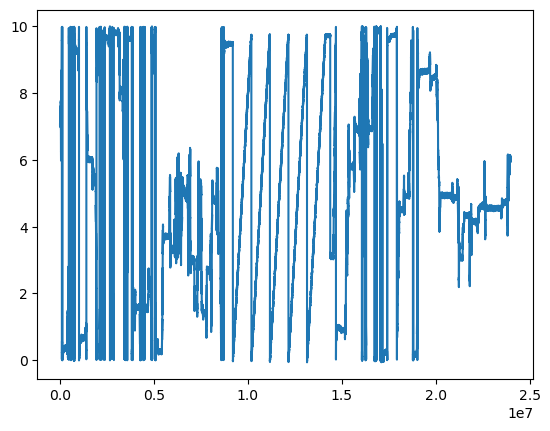

In [17]:
fig,ax = plt.subplots()
ax.plot(np.arange(df.shape[0]),df[' Heading'])

In [18]:
df.columns

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2'],
      dtype='object')

In [19]:
frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

In [20]:
df_aligned.head()

,Time(ms),Start Trigger,Opto Trigger,FicTrac Cam Exp.,FicTrac Frame Proc.,Heading,Y/Index,Arena DAC1,Arena DAC2,Heading_cartx,Heading_carty,Y/Index_cartx,Y/Index_carty,Arena DAC1_cartx,Arena DAC1_carty,Arena DAC2_cartx,Arena DAC2_carty
0,60.022736,1.0,0.0,1.0,29.0,-1.860456,0.001205,-1.835785,-3.088953,-0.285626,-0.958341,0.999998,0.001205,-0.261898,-0.965094,-0.998611,-0.052616
1,180.068208,0.0,0.0,0.0,56.0,-1.854288,0.004150,-1.837045,-3.091438,-0.279710,-0.960085,0.999991,0.004150,-0.263114,-0.964765,-0.998741,-0.050134
2,300.113680,0.0,0.0,0.0,57.0,-1.861758,0.003119,-1.836428,-3.090740,-0.286874,-0.957968,0.999995,0.003119,-0.262519,-0.964925,-0.998703,-0.050830
3,420.159152,0.0,0.0,0.0,56.0,-1.858553,0.000171,-1.837223,-3.092162,-0.283801,-0.958883,1.000000,0.000171,-0.263286,-0.964718,-0.998779,-0.049410
4,540.204624,0.0,0.0,0.0,57.0,-1.816454,0.005015,-1.837209,-3.090723,-0.243194,-0.969977,0.999987,0.005015,-0.263272,-0.964720,-0.998704,-0.050848


In [21]:
print(masks.shape)
np.isnan(data_corr).sum()

(7, 227, 257)


0

In [106]:
F, notF = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks, 16, bckgnd_mask = None, max_proj=False) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [107]:
print(F.shape)
print(notF.shape)
print(data_corr.shape)

(2, 16, 3999)
(2, 3999)
(2, 3999, 7, 227, 257)


In [108]:
import sklearn
from sklearn.linear_model import LinearRegression as LinReg


for ch in range(F.shape[0]):
    lr = LinReg().fit(notF[ch,np.newaxis, :].T, F[ch,:,:].T)
    F[ch,:,:] = F[ch,:,:]-1.*lr.predict(notF[ch,np.newaxis,:].T).T  + lr.intercept_[:,np.newaxis]

# lr = LinReg().fit(notF[0,np.newaxis, :].T, F[0,:,:].T)
# F[0,:,:] = F[0,:,:]-1.*lr.predict(notF[0,np.newaxis,:].T).T  + lr.intercept_[:,np.newaxis]

data_corr.shape
notF = sp.ndimage.gaussian_filter1d(notF,3,axis=-1)
F = sp.ndimage.gaussian_filter1d(F,2,axis=-1)
F = sp.ndimage.gaussian_filter1d(F,.5,axis=1, mode='wrap')

# F_base = sp.ndimage.gaussian_filter1d(np.copy(F),200,axis=-1)
F_base = np.percentile(F,10,axis=-1, keepdims=True)


whole_frame_ts = data_corr.mean(axis=-1).mean(axis=-1).mean(axis=-1)
# print(whole_frame_ts.shape)


In [109]:



# dff = (F[1,:,:]-F_base[1,:,:] - .2*notF[1,np.newaxis,:])/F_base[1,:,:] 
# dff = (F[0,:,:]-F_base[0,:,:])/F_base[0,:,:] 
# dff_r = (F[0,:,:]-F_base[0,:,:])/F_base[0,:,:]

# predict each timeseries from notF
# change notF to dark part of FOV

# dff = sp.stats.zscore(F[1,:,:]-1.*lr.predict(notF[1,:,np.newaxis]).T , axis=-1)
# dff = sp.stats.zscore(F[1,:,:]-.7*F[1,:,:].mean(axis=0,keepdims=True),axis=-1)
# dff = sp.stats.zscore(F[1,:,:],axis=-1)
dff = sp.stats.zscore(F[1,:,:]-F[1,:,:].mean(axis=0,keepdims=True),axis=-1)
# dff = (F[0,:,:]-1.*F_base[0,:,:])/F_base[0,:,:]
# dff_r = sp.stats.zscore(F[0,:,:]-.7*notF[0,np.newaxis,:],axis=-1)
dff_r = sp.stats.zscore(F[0,:,:],axis=-1)

# dff = sp.stats.zscore(F[1,:,:], axis = -1)
# dff_r = sp.stats.zscore(F[0,:,:], axis = -1) 



In [110]:
print(np.amin(dff),np.amax(dff))
print(np.amin(dff_r),np.amax(dff_r))

-3.9845287689389304 4.053382741651053
-3.2919927594905802 5.4510391786840495


In [111]:

x_f,y_f = st2p.utilities.pol2cart(dff,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])
x_f_r,y_f_r = st2p.utilities.pol2cart(dff_r,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])


_, heading = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), 
                                                           np.pi-1*df_aligned[' Heading'].to_numpy().ravel()))


rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

rho_r,phi_r = st2p.utilities.cart2pol(x_f_r.mean(axis=0), y_f_r.mean(axis=0))
_,offset_r = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_r-heading))


In [112]:
fig_folder = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/figs'
os.makedirs(fig_folder, exist_ok=True)

In [113]:
df_aligned.columns

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Y/Index_cartx',
       ' Y/Index_carty', ' Arena DAC1_cartx', ' Arena DAC1_carty',
       ' Arena DAC2_cartx', ' Arena DAC2_carty'],
      dtype='object')

(-1.0, 1.0)

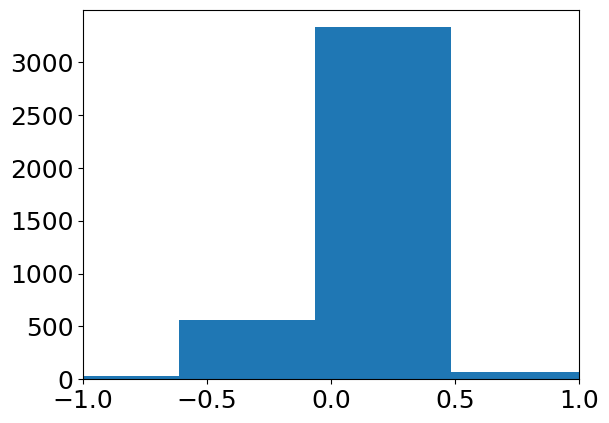

In [114]:
fig,ax = plt.subplots()
h_x, h_y = st2p.utilities.pol2cart(np.ones(heading.shape), np.diff(heading,prepend=0))
_, dh = st2p.utilities.cart2pol(h_x, h_y)
ax.hist(dh)
ax.set_xlim(-1,1)

# fig,ax = plt.subplots()
# ax.plot(heading[1500:1600])
# ax.plot(dh[1500:1600])

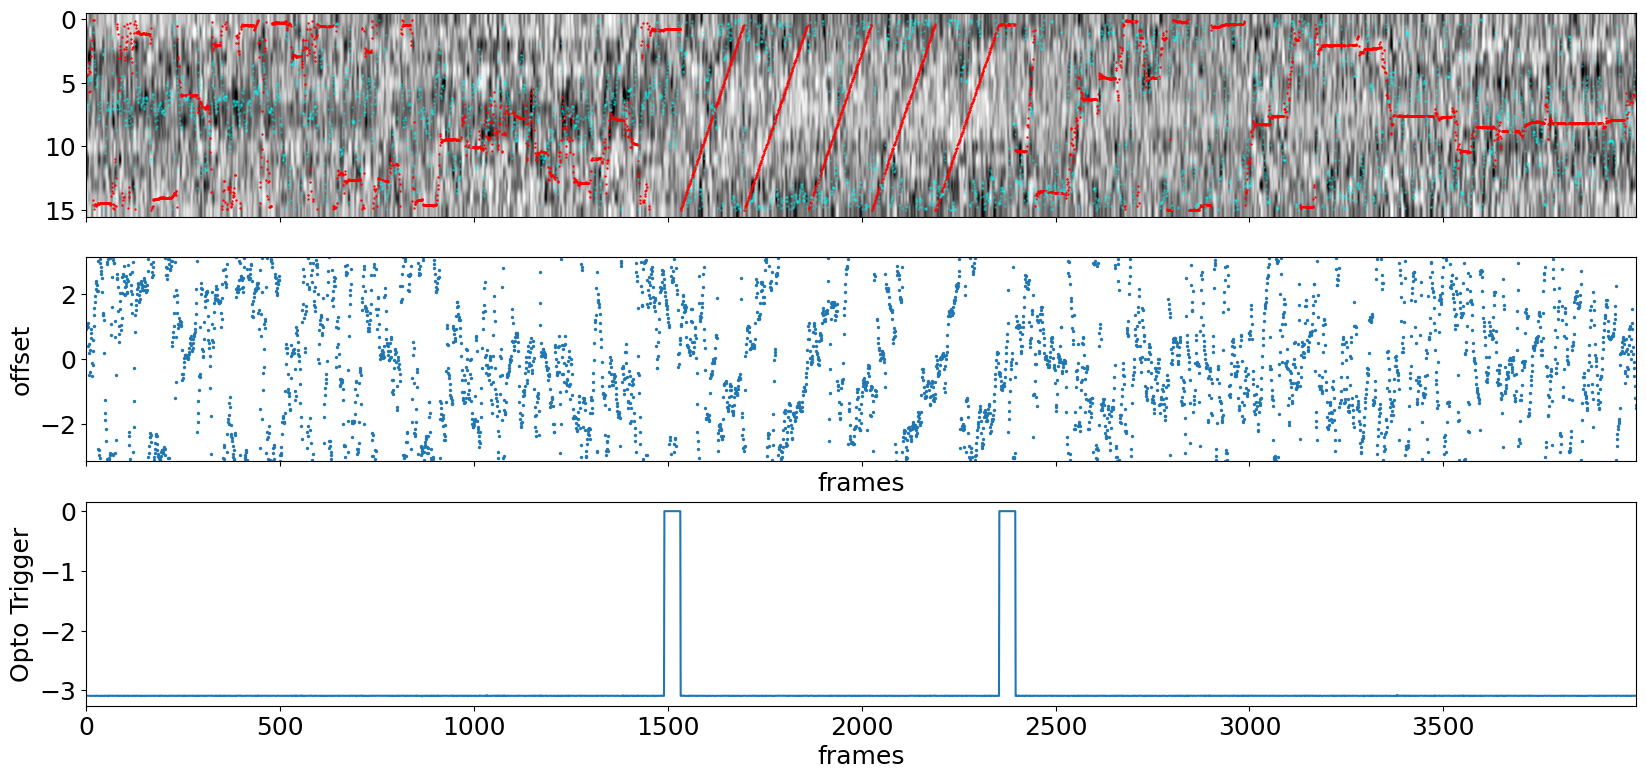

In [115]:
win_size = 6000

for num_fig, start_i in enumerate(range(0,dff.shape[-1]-3,win_size)):
    stop_i = min(start_i+win_size, dff.shape[-1]-1)
    window = slice(start_i, stop_i)
    fig, ax = plt.subplots(3,1,figsize=[20,9], sharex=True)
    dff_window = dff[:,window]
    ax[0].imshow(dff_window,aspect='auto',cmap='Greys',vmin=-3,vmax=3)
    x = np.arange(stop_i-start_i)
    ax[0].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='.', s=2)
    
    ax[0].scatter(x,15*(phi[window]+np.pi)/2/np.pi,color='cyan', s=1, alpha=.3)
    
    
    
    ax[1].scatter(x,offset[window],s=2)
    ax[1].set_ylim([-3.14,3.14])
    ax[1].set_ylabel('offset')
    ax[1].set_xlabel('frames')
    
    ax[2].plot(x,df_aligned[' Arena DAC2'].iloc[window])
    ax[2].set_ylabel('Opto Trigger')
    ax[2].set_xlabel('frames')
    
    
    fig.savefig(os.path.join(fig_folder,f'offset_{num_fig}.jpg'))


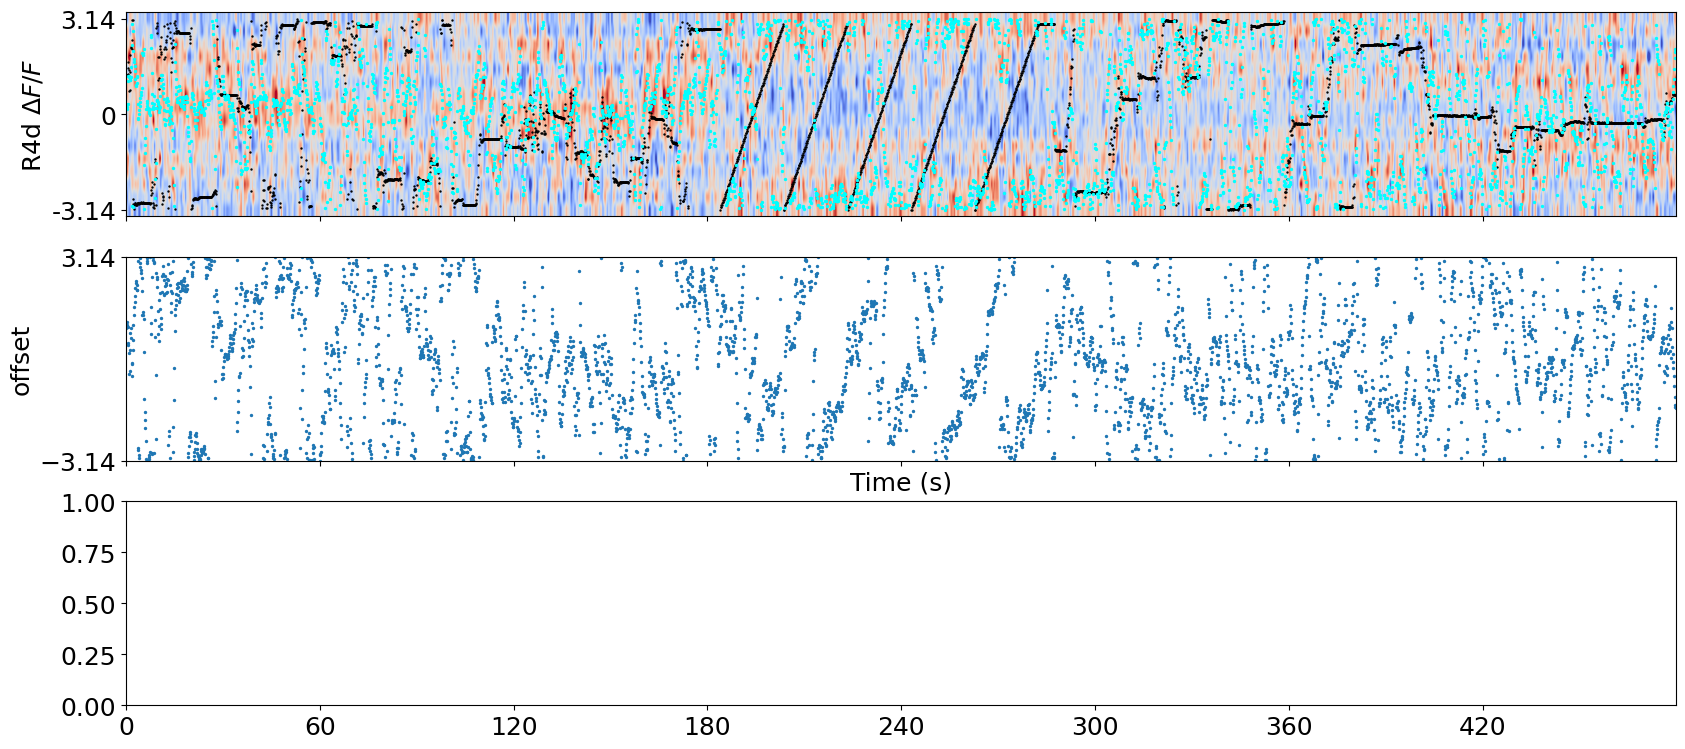

In [98]:

plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(3,1,figsize=[20,9], sharex=True)

# dff = dff[:,:1800]
# heading = heading[:1800]
# offset = offset[:1800]
# phi = phi[:1800]
ax[0].imshow(dff,aspect='auto',cmap='coolwarm', vmin=-3,vmax=3)#,vmin=-.5,vmax=3)
x = np.arange(dff.shape[-1])
ax[0].scatter(x,15*(heading+np.pi)/2/np.pi,color='black',marker='.', s=2)

ax[0].scatter(x,15*(phi+np.pi)/2/np.pi,color='cyan', s=2)

ax[0].set_yticks([0,7.5,15], ['3.14', '0', '-3.14'])
ax[0].set_ylabel(r"R4d $\Delta F/F$")

ax[1].scatter(x,offset,s=2)
ax[1].set_ylim([-3.14,3.14])
ax[1].set_yticks([-3.14,3.14])
ax[1].set_ylabel('offset')
ax[1].set_xlabel('frames')

# ax[2].plot(x,df_aligned[' Arena DAC2'])
# ax[2].set_ylabel('Opto Trigger')
ax[1].set_xlabel('Time (s)')

ax[1].set_xticks(x[0::500], labels=[str(int((frame_times[i]-frame_times[0])/1000)) for i in range(0,x[-1]+1,500)])

fig.savefig(os.path.join(fig_folder,f'offset_.jpg'))


-0.054754308437049336 0.0005321079433308925


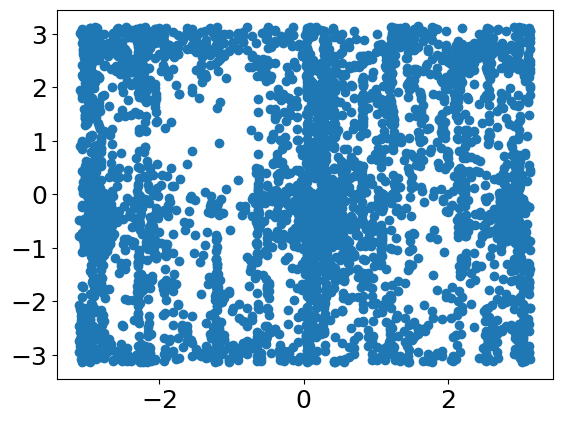

In [99]:
fig, ax = plt.subplots()
ax.scatter(heading, phi,cmap='Greys')
_, _heading = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), 
                                                           heading-np.pi))
r,p = sp.stats.pearsonr(_heading,phi)
print(r,p)

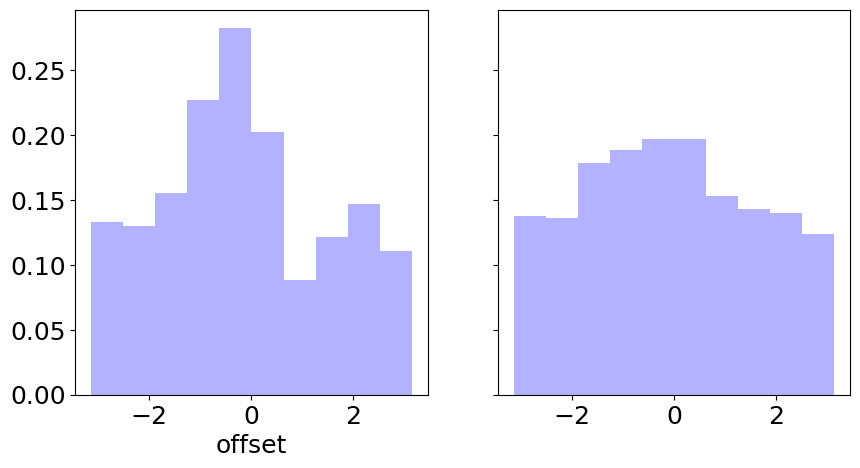

In [116]:
fig,ax = plt.subplots(1,2, figsize = [10,5],sharey=True)
_offset = offset[500:]
_dh = dh[500:]
ax[0].hist(_offset[np.abs(_dh)>.1],alpha=.3, color='blue',density=True)
                  # >f_aligned[' Arena DAC2']<-1],alpha=.3, color='blue',density=True)
ax[1].hist(offset,alpha=.3, color='blue',density=True)
ax[0].set_xlabel('offset')
fig.savefig(os.path.join(fig_folder,'offset_hist.jpg'))

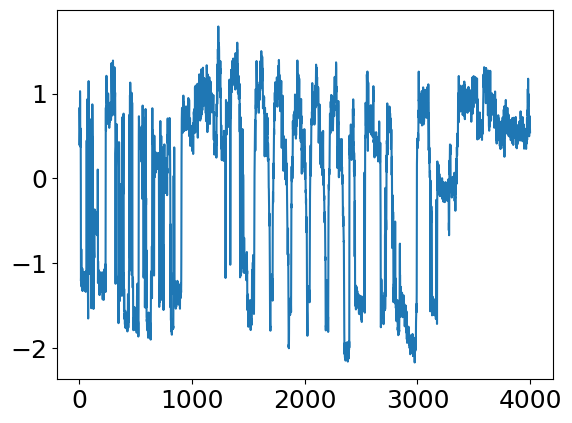

In [101]:
fig,ax = plt.subplots()
ax.plot(sp.stats.zscore(whole_frame_ts[0,:]))

Correlation beteween frame time and bump amplitude: r=-0.16958170025288283, p=1.7155265475193107e-20


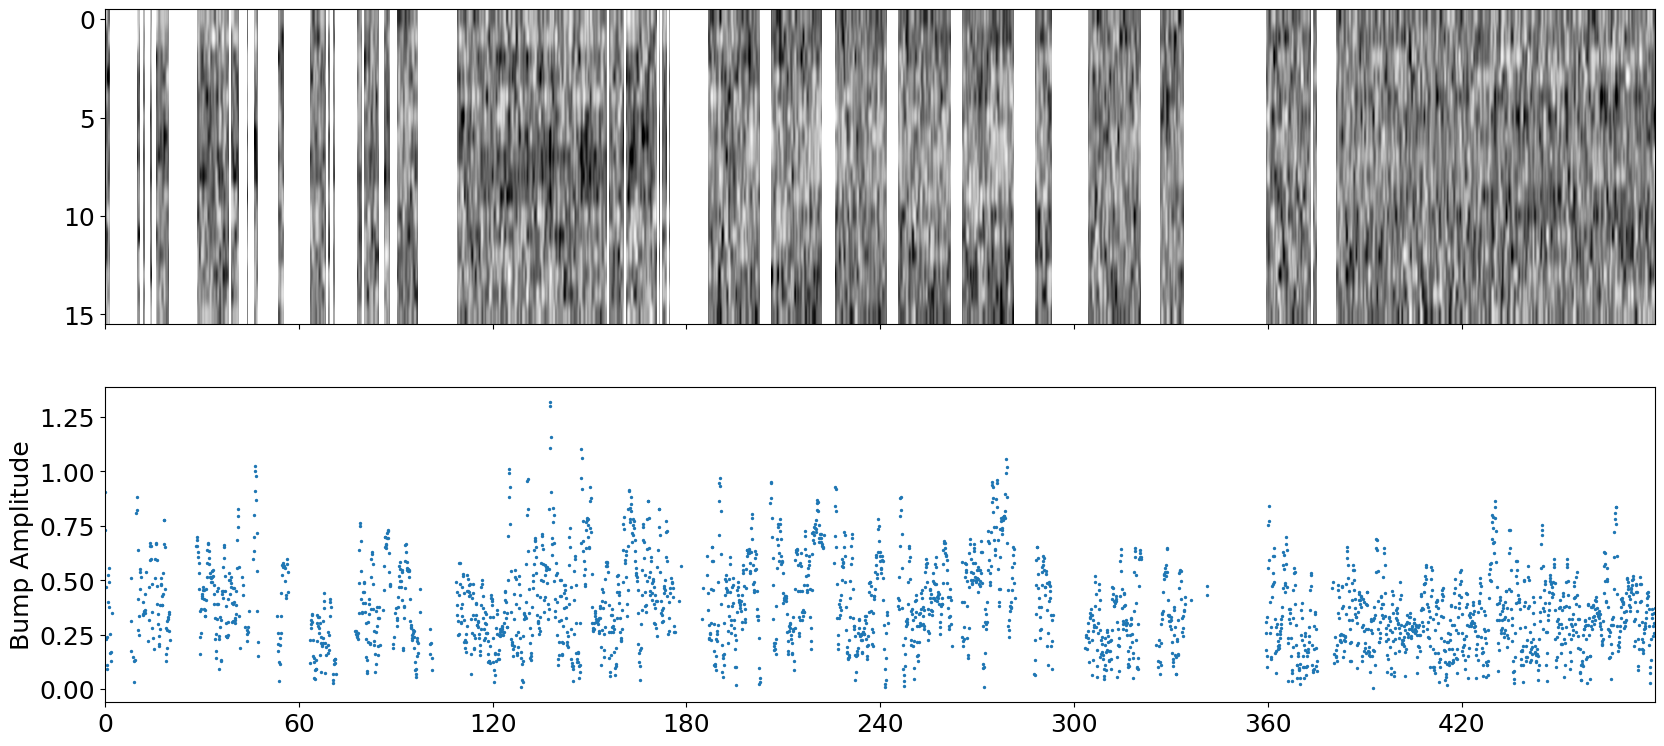

In [102]:
fig, ax = plt.subplots(2,1,figsize=[20,9], sharex=True)

opto_on = sp.stats.zscore(whole_frame_ts[0,:])<-1
dff[:,opto_on]=np.nan
rho[opto_on]=np.nan
ax[0].imshow(dff,aspect='auto',cmap='Greys', vmax=3)#,vmin=0,vmax=3)
ax[0].set_ylim([15.5,-.5])
x = np.arange(dff.shape[1])
# ax[0].plot(x, 15*np.roll(df_aligned[' Opto Trigger'].to_numpy(), int(.8/metadata['frame_period']/metadata['size']['z_planes'])))
# ax[0].plot(x, 15*np.roll(df_aligned[' Opto Trigger'].to_numpy(), int(6.6/metadata['frame_period']/metadata['size']['z_planes'])))
ax[0].set_xticks(x[::500], labels=[str(int(frame_times[int(i)]/1000)) for i in x[::500]] )

# ax[0].scatter(x,15*(phi+np.pi)/2/np.pi,color='black', s=2)


# ax[1].scatter(x,sp.ndimage.gaussian_filter1d(rho,1),s=2)
ax[1].scatter(x[~np.isnan(dff[0,:])],rho[~np.isnan(dff[0,:])],s=2)
ax[1].set_ylabel('Bump Amplitude')

r,p = sp.stats.pearsonr(frame_times[~np.isnan(rho)],rho[~np.isnan(rho)])
print(f"Correlation beteween frame time and bump amplitude: r={r}, p={p}")
# # ax[1].set_ylim([-3.14,3.14])
# # ax[1].plot(x,0*offset[window], marker='_')
# ax[1].set_ylabel('offset')
# ax[1].set_xlabel('frames')

# ax[2].plot(x,df_aligned[' Opto Trigger'].iloc[window])
# ax[2].set_ylabel('Opto Trigger')
# ax[2].set_xlabel('frames')

num_fig=0
fig.savefig(os.path.join(fig_folder,f'offset_{num_fig}.jpg'))


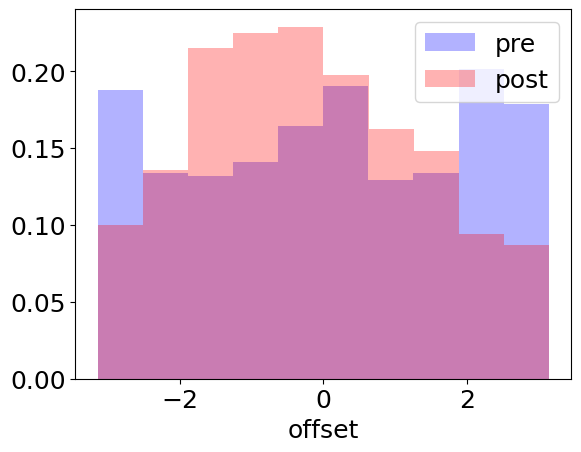

In [103]:
fig,ax = plt.subplots()
ax.hist(offset[:1500],alpha=.3, color='blue',density=True, label = 'pre')
ax.hist(offset[1800:],alpha=.3, color='red', density=True, label = 'post')
ax.set_xlabel('offset')
ax.legend()
fig.savefig(os.path.join(fig_folder,'offset_hist.jpg'))

In [104]:
df_aligned.columns

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Y/Index_cartx',
       ' Y/Index_carty', ' Arena DAC1_cartx', ' Arena DAC1_carty',
       ' Arena DAC2_cartx', ' Arena DAC2_carty'],
      dtype='object')

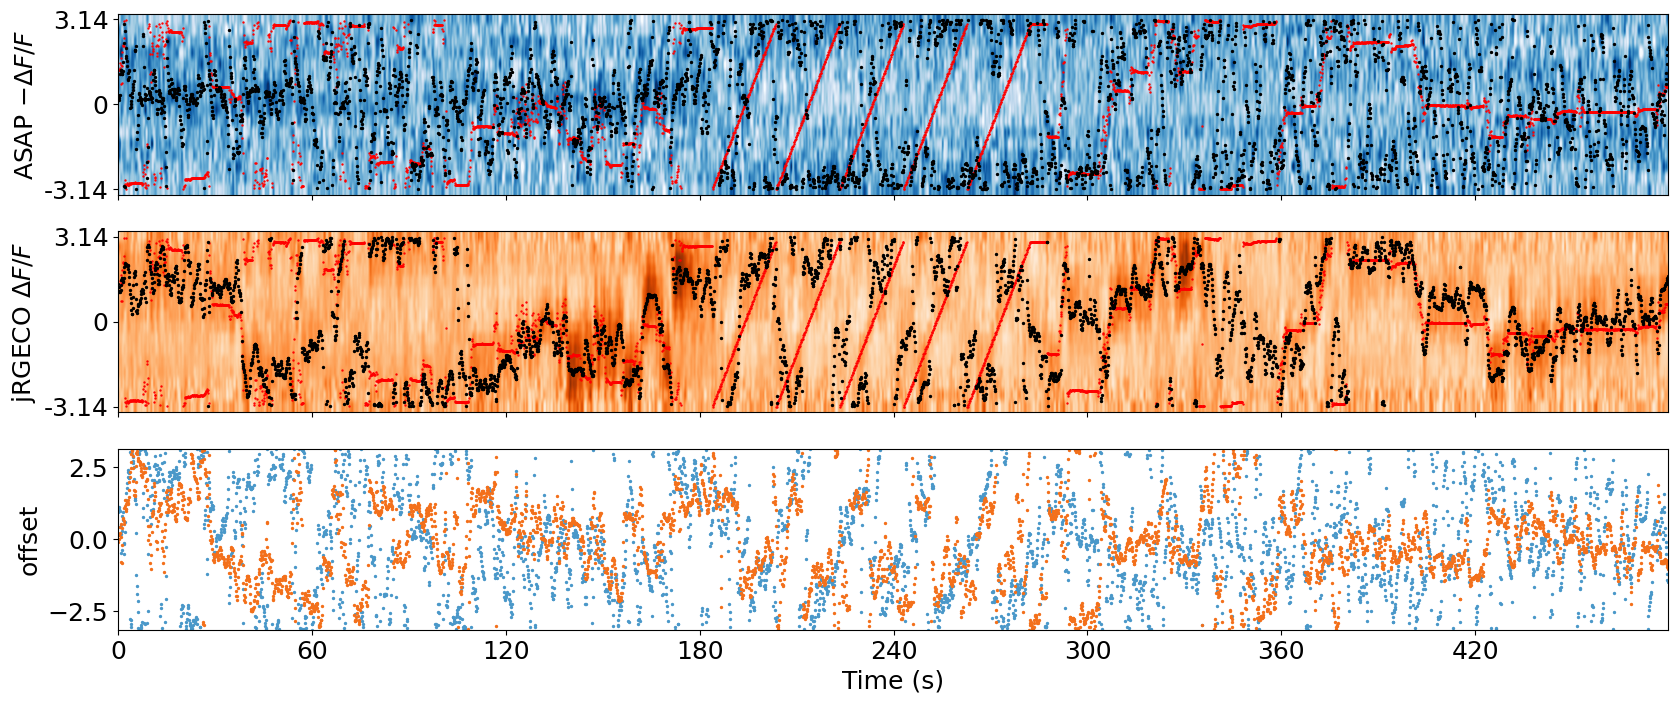

In [117]:
win_size = 6000
plt.rcParams.update({'font.size':18})

for num_fig, start_i in enumerate(range(0,dff.shape[-1]-3,win_size)):
    stop_i = min(start_i+win_size, dff.shape[-1]-1)
    window = slice(start_i, stop_i)
    x = np.arange(stop_i-start_i)
    
    fig, ax = plt.subplots(3,1,figsize=[20,8], sharex=True)
    dff_window = dff[:,window]
    ax[0].imshow(dff_window,aspect='auto',cmap='Blues',vmin=-3,vmax=3)
    # ax[0].set_xticks(frame_times)
    ax[0].set_yticks([0,7.5,15], ['3.14', '0', '-3.14'])
    ax[0].set_ylabel(r"ASAP $ - \Delta F/F$")
    # # ax[0].set_xticklabels([-3.14, 0, 3.14])

    ax[0].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='.',s=2)
    ax[0].scatter(x,15*(phi[window]+np.pi)/2/np.pi,color='black', s=2)

    dff_r_window = dff_r[:,window]
    ax[1].imshow(dff_r_window,aspect='auto',cmap='Oranges')#,vmin=-2,vmax=2)
    ax[1].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='.',s=2)
    ax[1].set_yticks([0,7.5,15], ['3.14', '0', '-3.14'])
    ax[1].set_ylabel(r"jRGECO $\Delta F/F$")
    ax[1].scatter(x,15*(phi_r[window]+np.pi)/2/np.pi,color='black', s=2)



    ax[2].scatter(x,offset[window],s=2, color=plt.cm.Blues(.6))
    ax[2].scatter(x,offset_r[window],s=2, color=plt.cm.Oranges(.6))
    ax[2].set_ylim([-3.14,3.14])
    # # ax[1].plot(x,0*offset[window], marker='_')


    ax[2].set_ylabel('offset')
    ax[2].set_xlabel('Time (s)')


    ax[2].set_xticks(x[0::500], labels=[str(int((frame_times[i]-frame_times[0])/1000)) for i in range(0,x[-1]+1,500)])
    


# fig.savefig(os.path.join(fig_folder,f'offset_{num_fig}.jpg'))

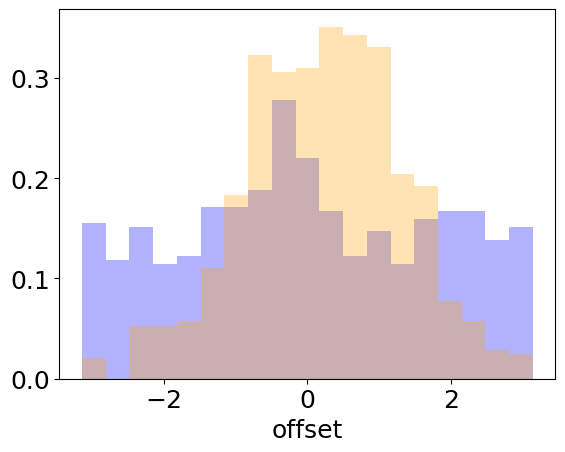

In [118]:
fig,ax = plt.subplots()
bin_edges=np.linspace(-np.pi,np.pi,num=20)
ax.hist(offset[np.abs(dh)>.1],bins = bin_edges, alpha=.3, color='blue',density=True)
ax.hist(offset_r[np.abs(dh)>.1],bins = bin_edges, alpha=.3, color='orange',density=True)
ax.set_xlabel('offset')
fig.savefig(os.path.join(fig_folder,'offset_hist.jpg'))

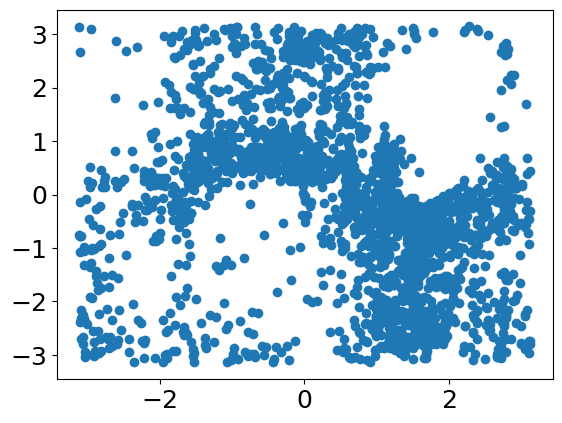

In [127]:
fig, ax = plt.subplots()
ax.scatter(heading[1600:-3],phi[1603:])


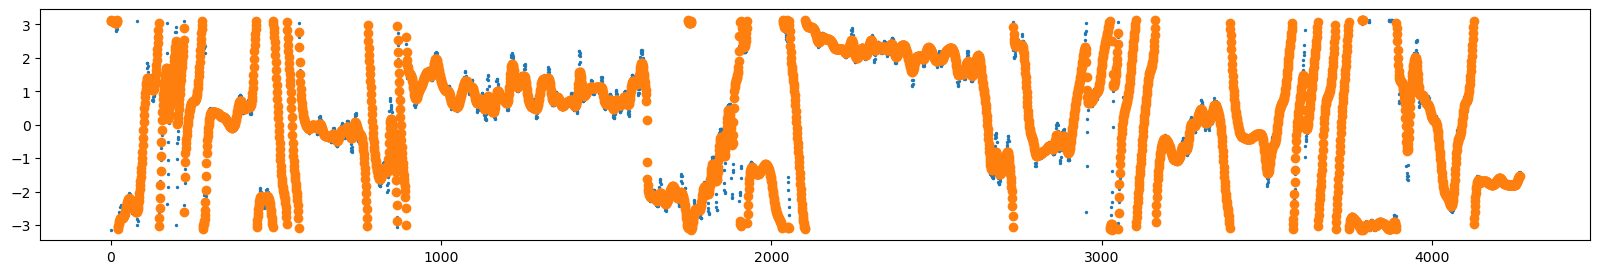

In [44]:
fig,ax = plt.subplots(figsize=[20,3])
ax.scatter(np.arange(offset.shape[0]),offset,s=2)
offset_cart_x, offset_cart_y = st2p.utilities.pol2cart(np.ones(offset.shape),offset)
_, offset_sm = st2p.utilities.cart2pol(sp.ndimage.gaussian_filter1d(offset_cart_x,5),sp.ndimage.gaussian_filter1d(offset_cart_y,5))
ax.scatter(np.arange(offset.shape[0]), offset_sm)

(array([196., 162., 206., 278., 190., 186., 233., 323., 304., 478., 405.,
        320., 210., 404., 201., 170.]),
 array([-3.14068899e+00, -2.74813816e+00, -2.35558733e+00, -1.96303650e+00,
        -1.57048567e+00, -1.17793484e+00, -7.85384013e-01, -3.92833183e-01,
        -2.82353929e-04,  3.92268475e-01,  7.84819305e-01,  1.17737013e+00,
         1.56992096e+00,  1.96247179e+00,  2.35502262e+00,  2.74757345e+00,
         3.14012428e+00]),
 <BarContainer object of 16 artists>)

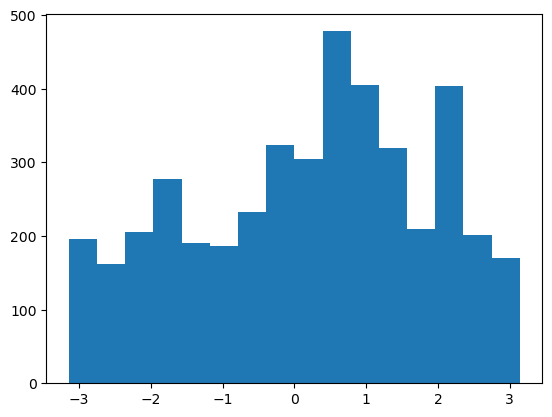

In [45]:
fig, ax = plt.subplots()
ax.hist(offset,bins=16)

In [11]:
data.shape

(2, 3280, 7, 208, 259)